In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import os
import glob
import seaborn as sns
from scipy import stats
import statsmodels.stats.api as sms
import cv2
gait_dir = '/Users/iwoods/Documents/GitHub/gait/'
this_dir = os.getcwd()
os.chdir(gait_dir)
import gaitFunctions
from gaitFunctions import pairwiseStats
import combineClips
import plotClip
os.chdir(this_dir)
def meanstdstr(vals):
    return str(np.round(np.mean(vals),2)) + ' ± ' + str(np.round(np.std(vals),2))

In [2]:
# plot colors and parameters
axis_fontsize=11
tick_fontsize=9

# colors for step kinematics
stance_color = '#5656ff'
swing_color = '#e1e813'
duty_color = '#4d4d4d'
ipsi_color = 'tab:red'
contra_color = 'tab:green'
mcl_color = 'tab:orange'

# colors for legs
first_pair_color = '#b45eff' # lavender
first_pair_color_alt = '#661f99' # purple
second_pair_color = '#006f2a' # green
second_pair_color_alt = '#02db55' # light green
third_pair_color = '#ffd500' # yellow
third_pair_color_alt = '#fa9805' # orange
rear_leg_color = '#00b6eb'# light blue
rear_leg_color_alt = '#0010eb' # dark blue

# scatter marker size and alpha
marker_size = 10
marker_alpha = 0.7
marker_color = 'k'

# Option 1: Select the folders to include in the analysis ... (or see below)

In [ ]:
# # navigate to directory that contains the data
# main_dir = '/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/videos_disulfiram/'
# os.chdir(main_dir)
# # list directories within this directory
# dirs = []
# for dirname, dirnames, filenames in os.walk('.'):
#     # print path to all subdirectories first.
#     for subdirname in dirnames:
#         folder = os.path.join(dirname, subdirname).split('/')[1]
#         if folder not in dirs:
#             dirs.append(folder)
# dirs = np.sort(np.unique(np.array(dirs)))
# dirs = [x for x in dirs if 'disulfiram' in x.lower()] # change to babies or adults or ramazzottius or disulfiram
# folders_in_analysis = gaitFunctions.selectMultipleFromList(dirs) 

# Option 2: Manually select the folders

In [3]:
main_dir = '/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/'
base_dir = '/Users/iwoods/Library/CloudStorage/OneDrive-IthacaCollege/2024_movement_disorder_paper/'
folders_in_analysis = [base_dir + 'videos_disulfiram/Disulfiram 12Jan24 Inverted',
                       base_dir + 'videos_disulfiram/Disulfiram 13Dec23 Inverted',
                       base_dir + 'videos_disulfiram/Disulfiram 16Dec22 Inverted',
                       base_dir + 'videos_disulfiram/Disulfiram 8Dec22 Inverted',
]
control = 'control'
experimental = 'disulfiram'

In [ ]:
main_dir = '/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/'
base_dir = '/Users/iwoods/Library/CloudStorage/OneDrive-IthacaCollege/2024_movement_disorder_paper/'
folders_in_analysis = [base_dir + 'videos_wild/ramazzottius_14Sep23',
                       base_dir + 'videos_wild/ramazzottius_21Sep23',
                       base_dir + 'videos_exemplaris/iw_11Dec23_exemplaris_inverted',
                       base_dir + 'videos_exemplaris/iw_18Jan24_exemplaris_inverted',
                       base_dir + 'videos_exemplaris/iw_21Dec23_exemplaris_inverted',
                       base_dir + 'videos_exemplaris/iw_9Nov23_exemplaris_inverted'
]
control = 'exemplaris'
experimental = 'ramazzottius'

In [ ]:
main_dir = '/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/'
base_dir = '/Users/iwoods/Library/CloudStorage/OneDrive-IthacaCollege/2024_movement_disorder_paper/'
folders_in_analysis = [base_dir + 'videos_babies/adults_28Nov',
                       base_dir + 'videos_babies/babies_15Sep',
]
control = 'adult'
experimental = 'juvenile'

# Load the data from the selected folders

In [4]:
### in each folder, look for a 'combined' excel file and load (or append) it to a dataframe
# if there is no 'combined' excel file, run combineClips and then load the file
os.chdir(main_dir)

path_summaries_df = pd.DataFrame()
step_timing_df = pd.DataFrame()
step_summaries_df = pd.DataFrame()
gait_summaries_df = pd.DataFrame()
gait_styles_speeds_df = pd.DataFrame()

def appendDF(original,new):
    if len(original) == 0:
        original = new
    else:
        new = pd.concat([original, new])
    return new

for folder in folders_in_analysis:
    os.chdir(folder)
    combined_files = sorted(glob.glob('*combined*xlsx'))
    if len(combined_files) == 0:
        print('Combining .xlsx files in ' + folder)
        pdf, stcdf, sdf, gdf, gssdf = combineClips.main(True)
    elif len(combined_files) == 1:
        excel_file = combined_files[0]
        print('Found ' + combined_files[0])
        
        # read in data from this excel file
        pdf = pd.read_excel(excel_file, sheet_name='path_summaries', index_col=None)
        stdf = pd.read_excel(excel_file, sheet_name='step_timing', index_col=None)
        sdf = pd.read_excel(excel_file, sheet_name='step_summaries', index_col=None)
        gdf = pd.read_excel(excel_file, sheet_name='gait_summaries', index_col=None)
        gssdf = pd.read_excel(excel_file, sheet_name='gait_speeds', index_col=None)
        
        # append to existing dataframe
        path_summaries_df = appendDF(path_summaries_df, pdf)
        step_timing_df = appendDF(step_timing_df, stdf)
        step_summaries_df = appendDF(step_summaries_df, sdf)
        gait_summaries_df = appendDF(gait_summaries_df, gdf)
        gait_styles_speeds_df = appendDF(gait_styles_speeds_df, gssdf)
    else:
        print('Too many "combined" files in ' + folder)
    os.chdir(main_dir)
path_summaries_df.head(5)

Found Disulfiram 12Jan24 Inverted_combined.xlsx
Found Disulfiram 13Dec23 Inverted_combined.xlsx
Found Disulfiram 16Dec22 Inverted_combined.xlsx
Found Disulfiram 8Dec22 Inverted_combined.xlsx


,Identifier,treatment,individual,date,Scale (pixels in 1mm),Body Size (mm^2),Body Length (mm),Body Width (mm),Body Width/Length Ratio,Duration analyzed (sec),...,Percentage of time cruising,Speed (mm/sec cruising),Speed (body lengths / sec cruising),Total bearing change (deg),Bearing change (deg) / sec,Bearing change (deg) / sec cruising,Number of stops,Stops / sec,Number of turns,Turns / sec
0,iw_12jan_tardigrade01_control,control,tardigrade01,12jan,956.03,0.012985,0.238598,0.073853,0.309530,99.5535,...,87.693710,0.044907,0.188211,2377.436000,23.880989,15.608393,13,0.130583,8,0.080359
1,iw_12jan_tardigrade01_disulfiram,disulfiram,tardigrade01,12jan,956.03,0.011568,0.211995,0.075648,0.356837,167.7272,...,45.709124,0.031727,0.149659,6954.287733,41.461896,22.670600,61,0.363686,44,0.262331
2,iw_12jan_tardigrade02_control,control,tardigrade02,12jan,956.03,0.014216,0.247831,0.077100,0.311102,115.2875,...,83.013914,0.042615,0.171954,2330.605200,20.215593,16.363241,18,0.156131,9,0.078066
3,iw_12jan_tardigrade02_disulfiram,disulfiram,tardigrade02,12jan,956.03,0.014620,0.250047,0.079605,0.318362,107.3940,...,72.262980,0.039543,0.158144,2297.907267,21.396980,15.860098,22,0.204853,7,0.065181
4,iw_12jan_tardigrade03_control,control,tardigrade03,12jan,956.03,0.011513,0.225085,0.068042,0.302294,110.8947,...,96.098226,0.052538,0.233415,1536.464000,13.855162,10.619561,4,0.036070,4,0.036070


In [5]:
# col = 'Speed (body lengths / sec cruising)'
col = 'Body Length (mm)'
length_df = path_summaries_df[['Identifier',col,'treatment']]
c_length = np.nanmean(length_df[length_df['treatment']==control][col].values)
print(control, c_length)
e_length = np.nanmean(length_df[length_df['treatment']!=control][col].values)
print(experimental, e_length)
length_df[length_df['treatment']==control].sort_values(by=col)

control 0.25891602598158087
disulfiram 0.23268204588714198


,Identifier,Body Length (mm),treatment
0,iw_8dec_tardigrade01_control,0.183737,control
8,iw_8dec_tardigrade05_control,0.215057,control
4,iw_13dec_tardigrade03_control,0.220247,control
4,iw_12jan_tardigrade03_control,0.225085,control
8,iw_12jan_tardigrade05_control,0.237220,control
0,iw_12jan_tardigrade01_control,0.238598,control
12,iw_13dec_tardigrade07_control,0.239560,control
6,iw_13dec_tardigrade04_control,0.246961,control
2,iw_12jan_tardigrade02_control,0.247831,control
6,iw_12jan_tardigrade04_control,0.252970,control


# Selecting data to analyze

In [6]:
# Path Data
print(path_summaries_df.columns)
path_cols =[
#     'Body Size (mm^2)', 
    'Body Length (mm)',
#     'Body Width (mm)', 
    'Body Width/Length Ratio', 
#     'Duration analyzed (sec)',
#     'Distance traveled (mm)', 
#     'Percentage of time cruising', # this is basically body length / sec, and inverse of stops / sec
#     'Speed (mm/sec)',
#     'Speed (body lengths / sec)', 
#     'Speed (mm/sec cruising)', 
    'Speed (body lengths / sec cruising)',
#     'Total bearing change (deg)', 
#     'Bearing change (deg) / sec',
    'Bearing change (deg) / sec cruising', 
#     'Number of stops', 
    'Stops / sec', # this is basically just the inverse of % cruising
#     'Number of turns', 
#     'Turns / sec'
]
print(len(path_cols))

Index(['Identifier', 'treatment', 'individual', 'date',
       'Scale (pixels in 1mm)', 'Body Size (mm^2)', 'Body Length (mm)',
       'Body Width (mm)', 'Body Width/Length Ratio', 'Duration analyzed (sec)',
       'Distance traveled (mm)', 'Speed (mm/sec)',
       'Speed (body lengths / sec)', 'Percentage of time cruising',
       'Speed (mm/sec cruising)', 'Speed (body lengths / sec cruising)',
       'Total bearing change (deg)', 'Bearing change (deg) / sec',
       'Bearing change (deg) / sec cruising', 'Number of stops', 'Stops / sec',
       'Number of turns', 'Turns / sec'],
      dtype='object')
5


In [7]:
# STEP KINEMATICS
# print(step_summaries_df.columns) # working need to update all of these - rerun analyzeSteps and combineClips
step_cols = [
    'Stance duration (lateral legs)', 
    'Swing duration (lateral legs)',
#     'Gait cycle (lateral legs)', 
#     'Duty factor (lateral legs)',
    'mm per step (lateral legs)', 
    'bodylength per step (lateral legs)',
    'Stance duration (rear legs)', 
    'Swing duration (rear legs)',
#     'Gait cycle (rear legs)', 
#     'Duty factor (rear legs)',
#     'mm per step (rear legs)', 
    'bodylength per step (rear legs)', 
#     'Metachronal lag (lateral legs)',
#     'Metachronal lag (normalized, lateral legs)',
#     'Metachronal lag Abs (Left-Right Ratio)',
#     'Metachronal lag ratios per L3 step', # transformed this to
    'Abs MCL Ratio per L3',
#     'Bearing change per L3 step',
#     'Anterior swing offsets (lateral legs)',
    'Anterior swing offsets (normalized, lateral legs)',
#     'Opposite swing offsets (lateral legs)',
    'Opposite swing offsets (normalized, lateral legs)',
#     'Opposite swing offsets (rear legs)',
    'Opposite swing offsets (normalized, rear legs)']
print(len(step_cols))

11


In [8]:
print(step_summaries_df['Abs MCL Ratio per L3'].values)
print(step_summaries_df['Metachronal lag Abs (Left-Right Ratio)'].values)
# nan's and values should roughly match up ... 
# OK for disulfiram
# OK - ish ... for juveniles
# kinda weird for ramazzottius

[0.49208162 0.34383084 0.70393877 0.70341271 0.12617302 0.28965431
 0.7392172  0.5455952  0.63020131        nan 0.63495483        nan
 0.48751465 0.53570792 0.25211872 0.42722047 0.60988693 0.18218111
 0.58906517        nan 0.60499233 0.2622974  0.77980806 0.51290942
 0.21515449 0.17964329 0.06481892 0.4586413  0.24948502 0.69295035
 0.78751466 0.78554976 0.22569169 0.63712938 0.58102985 0.39806759
 0.39880297 0.28082142 0.42968189 0.44059258 0.70891274 0.28151664
 0.38492785 0.41844964]
[0.50661417 0.04078019 0.62800148 0.54339152 0.04015267 0.10754926
 0.63140379 0.59162524 0.67192826        nan 0.39465944        nan
 0.36814153 0.51597253 0.07784585 0.24143528 0.6186948  0.02347682
 0.4537234         nan 0.58044219 0.2211682  0.79604815 0.48973472
 0.08013681 0.04468043 0.16061206 0.21640243 0.06458497 0.52196905
 0.27130202 0.7403296  0.03866162 0.05622214 0.26309545 0.31353319
 0.20362711 0.25187607 0.33681157 0.32595802 0.75120592 0.17071014
 0.50543563 0.33966469]


In [9]:
# GAIT STYLES
# print(gait_summaries_df.columns)
gait_cols = [
#     '% stand (lateral legs)',
#     '% pentapod (lateral legs)',
    '% tetrapod canonical (lateral legs)',
#     '% tetrapod gallop (lateral legs)', 
#     '% tetrapod other (lateral legs)',
#     '% tetrapod total (lateral legs)', 
    '% tripod canonical (lateral legs)',
#     '% tripod other (lateral legs)', 
#     '% tripod total (lateral legs',
#     '% other (lateral legs)',
#     '% stand (rear legs)', 
#     '% hop (rear legs)',
    '% step (rear legs)',
    'Tetrapod Coordination Strength',
#     'Tetrapod Bout Speed (bodylength / s)',
    'Tripod Coordination Strength',
#     'Tripod Bout Speed (bodylength / s)'
#     'CLR tetrapod canonical (lateral legs)',
#     'CLR tripod canonical (lateral legs)',
#     'CLR step (rear legs)'
]
print(len(gait_cols))

5


# Exploring the data

In [10]:
def mergeDataframes(dflist,col='Identifier'):
    df = dflist[0].copy()
    for i in np.arange(len(dflist[:-1])):
        df = df.merge(dflist[i+1],on=col)
    return df

In [11]:
merged_df = mergeDataframes([path_summaries_df, step_summaries_df, gait_summaries_df])
merged_df.columns

Index(['Identifier', 'treatment_x', 'individual_x', 'date_x',
       'Scale (pixels in 1mm)', 'Body Size (mm^2)', 'Body Length (mm)',
       'Body Width (mm)', 'Body Width/Length Ratio', 'Duration analyzed (sec)',
       'Distance traveled (mm)', 'Speed (mm/sec)',
       'Speed (body lengths / sec)', 'Percentage of time cruising',
       'Speed (mm/sec cruising)', 'Speed (body lengths / sec cruising)',
       'Total bearing change (deg)', 'Bearing change (deg) / sec',
       'Bearing change (deg) / sec cruising', 'Number of stops', 'Stops / sec',
       'Number of turns', 'Turns / sec', 'treatment_y', 'individual_y',
       'Stance duration (lateral legs)', 'Swing duration (lateral legs)',
       'Gait cycle (lateral legs)', 'Duty factor (lateral legs)',
       'mm per step (lateral legs)', 'bodylength per step (lateral legs)',
       'Stance duration (rear legs)', 'Swing duration (rear legs)',
       'Gait cycle (rear legs)', 'Duty factor (rear legs)',
       'mm per step (rear legs)'

In [12]:
df = merged_df.copy() # merged_df or path_summaries_df step_summaries_df gait_summaries_df
analysis_cols = ['treatment'] + step_cols + path_cols + gait_cols
df = df[analysis_cols]

In [13]:
df.count()
# df.describe()

treatment                                            44
Stance duration (lateral legs)                       44
Swing duration (lateral legs)                        44
mm per step (lateral legs)                           44
bodylength per step (lateral legs)                   44
Stance duration (rear legs)                          44
Swing duration (rear legs)                           44
bodylength per step (rear legs)                      44
Abs MCL Ratio per L3                                 41
Anterior swing offsets (normalized, lateral legs)    44
Opposite swing offsets (normalized, lateral legs)    44
Opposite swing offsets (normalized, rear legs)       44
Body Length (mm)                                     44
Body Width/Length Ratio                              44
Speed (body lengths / sec cruising)                  44
Bearing change (deg) / sec cruising                  44
Stops / sec                                          44
% tetrapod canonical (lateral legs)             

In [14]:
# change 'treatment' to category datatype, and see how many we have (there should be 2)
df['treatment'] = df['treatment'].astype('category')
df.describe(include='category')

,treatment
count,44
unique,2
top,control
freq,24


In [15]:
# dummy variable for treatment
# control = 'exemplaris' # control or exemplaris or adult ... usually set above while loading folders
df['Condition'] = np.where(df['treatment'] == control, 0, 1)
df.head(3)

,treatment,Stance duration (lateral legs),Swing duration (lateral legs),mm per step (lateral legs),bodylength per step (lateral legs),Stance duration (rear legs),Swing duration (rear legs),bodylength per step (rear legs),Abs MCL Ratio per L3,"Anterior swing offsets (normalized, lateral legs)",...,Body Width/Length Ratio,Speed (body lengths / sec cruising),Bearing change (deg) / sec cruising,Stops / sec,% tetrapod canonical (lateral legs),% tripod canonical (lateral legs),% step (rear legs),Tetrapod Coordination Strength,Tripod Coordination Strength,Condition
0,control,0.809456,0.251526,0.037117,0.155593,0.463111,0.298444,0.088419,0.492082,0.351333,...,0.309530,0.188211,15.608393,0.130583,29.444444,0.000,75.833333,0.375235,NaN,0
1,disulfiram,1.094946,0.335081,0.037428,0.176039,0.549176,0.461471,0.088320,0.343831,0.605835,...,0.356837,0.149659,22.670600,0.363686,36.363636,0.000,83.746556,0.443529,NaN,1
2,control,0.983225,0.271788,0.041833,0.169110,0.628057,0.352057,0.107146,0.703939,0.561529,...,0.311102,0.171954,16.363241,0.156131,26.875000,0.625,67.968750,0.404162,0.26652,0


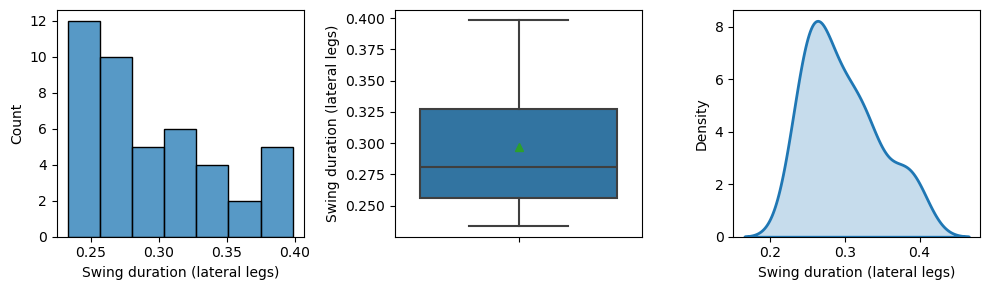

In [16]:
# looking at ALL data for a specified column
col = 'Swing duration (lateral legs)'
f,[a1,a2,a3] = plt.subplots(1,3,figsize=(10,3))
a1=sns.histplot(ax=a1, x=df[col])
a2=sns.boxplot(ax=a2, y=df[col], showmeans=True)
a3=sns.kdeplot(ax=a3, x=df[col], fill=True, linewidth=2);
plt.tight_layout()
plt.show()

Swing duration (lateral legs)


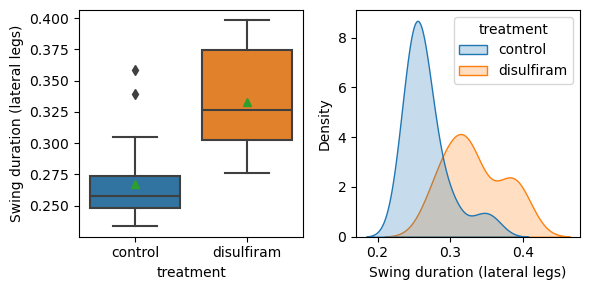

In [17]:
# comparing control vs. treatment for a specified column (col)
f,(a1,a2) = plt.subplots(1,2,figsize=(6,3))
print(col)
sns.boxplot(ax=a1, x=df['treatment'], y=df[col], showmeans=True)
sns.kdeplot(ax=a2, x=col, hue='treatment', data=df, fill=True)
plt.tight_layout()
plt.show()

Swing duration (lateral legs)


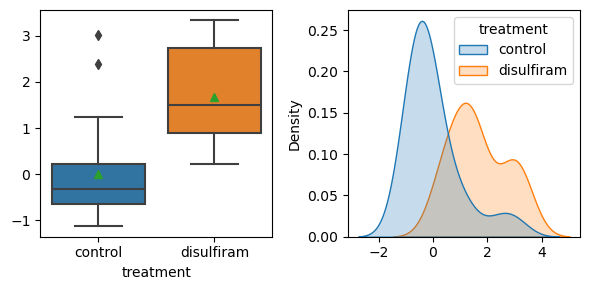

In [18]:
# Converting to ZSCORES (ended up not going in this direction . . . )
f,(a1,a2) = plt.subplots(1,2,figsize=(6,3))
print(col)
conditions = df['Condition'].values
zscores = np.zeros(len(df[col].values))
control_data = df[df['Condition']==0][col].values
exp_data = df[df['Condition']==1][col].values
control_mean = np.nanmean(control_data)
control_std = np.nanstd(control_data)
exp_std = np.nanstd(exp_data)

for i, val in enumerate(df[col].values):
    if conditions[i] == 0: # control
        zscores[i] = (val-control_mean) / control_std
    elif conditions[i] == 1: # exp
        zscores[i] = (val-control_mean) / exp_std

sns.boxplot(ax=a1, x=df['treatment'], y=zscores, showmeans=True)
sns.kdeplot(ax=a2, x=zscores, hue='treatment', data=df, fill=True)
plt.tight_layout()
plt.show()

In [19]:
# T-test using fancy statsmodels
control_data = df[df['Condition']==0][col].values
exp_data = df[df['Condition']==1][col].values
levene=stats.levene(control_data, exp_data)
if levene.pvalue < 0.1:
    var = 'unequal'
    print('unequal variance')
else:
    var = 'pooled'
model = sms.CompareMeans.from_data(control_data, exp_data)
print(model.summary(usevar=var))

                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1     -0.0654      0.011     -6.100      0.000      -0.087      -0.044


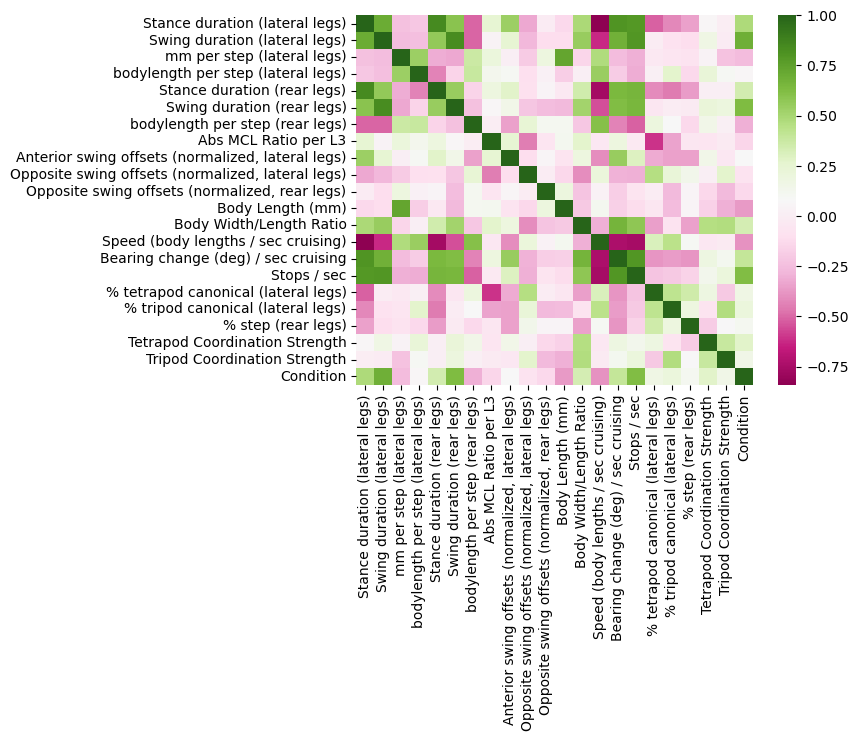

In [21]:
# looking for correlations within the dataset
corrmat = df.corr()#(numeric_only=True)
sns.heatmap(corrmat,cmap='PiYG') # 'bwr' # https://matplotlib.org/stable/users/explain/colors/colormaps.html
plt.show()

# Linear Regression 
### aka ANCOVA (analysis of covariance sez Brooks)

In [22]:
# Try a linear regression with X as 'Condition' and Y as a column of interest
import statsmodels.api as sm
Y = df[col] # col is from above, or reset here
X = df['Condition']
X = sm.add_constant(X)
model = sm.OLS(Y, X, missing='drop')
model_result = model.fit()
model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Swing duration (lateral legs)   R-squared:                       0.470
Model:                                       OLS   Adj. R-squared:                  0.457
Method:                            Least Squares   F-statistic:                     37.21
Date:                           Wed, 21 Feb 2024   Prob (F-statistic):           2.85e-07
Time:                                   12:30:33   Log-Likelihood:                 85.584
No. Observations:                             44   AIC:                            -167.2
Df Residuals:                                 42   BIC:                            -163.6
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2673      0.007     36.984      0.000       0.253       0.282
Condition      0.0654      0.011      6.100      0.000       0.044       0.087
==============================================================================
Omnibus:                        5.566   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                5.028
Skew:                           0.828   Prob(JB):                       0.0809
Kurtosis:                       3.023   Cond. No.                         2.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

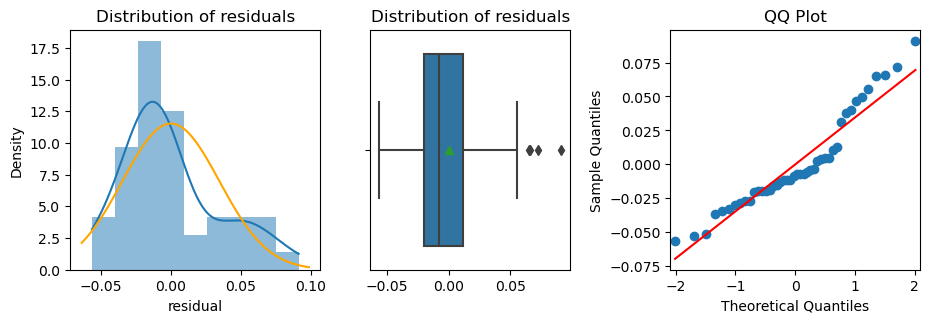

In [23]:
# check residuals from linear regression - are they normally distributed?
fig = plt.figure(figsize=(10,3))
ax1 = fig.add_axes([0.1,0.1,0.25,0.8])
ax2 = fig.add_axes([0.4,0.1,0.2,0.8])
ax3 = fig.add_axes([0.7,0.1,0.25,0.8])

mu, std = stats.norm.fit(model_result.resid)

# plot the residuals
sns.histplot(ax=ax1, x=model_result.resid, stat="density", linewidth=0, kde=True)
ax1.set(title="Distribution of residuals", xlabel="residual")

# plot corresponding normal curve
xmin, xmax = ax1.get_xlim() # the maximum x values from the histogram above
x = np.linspace(xmin, xmax, 100) # generate some x values
p = stats.norm.pdf(x, mu, std) # calculate the y values for the normal curve
sns.lineplot(ax=ax1, x=x, y=p, color="orange")

sns.boxplot(ax=ax2, x=model_result.resid, showmeans=True)
ax2.set(title="Distribution of residuals")

sm.qqplot(model_result.resid, line='s',ax=ax3)
ax3.set(title="QQ Plot")

plt.show()

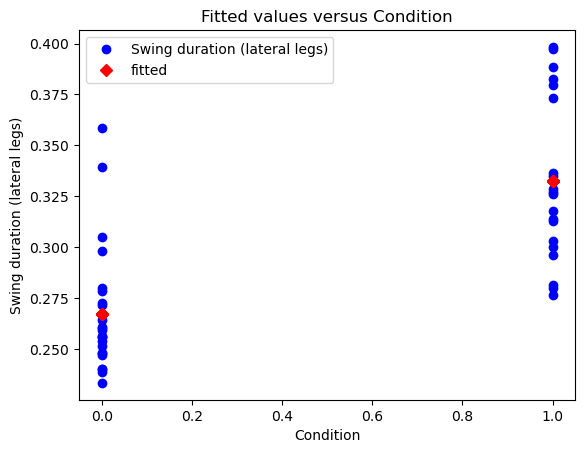

In [24]:
sm.graphics.plot_fit(model_result,1, vlines=False)
plt.show()

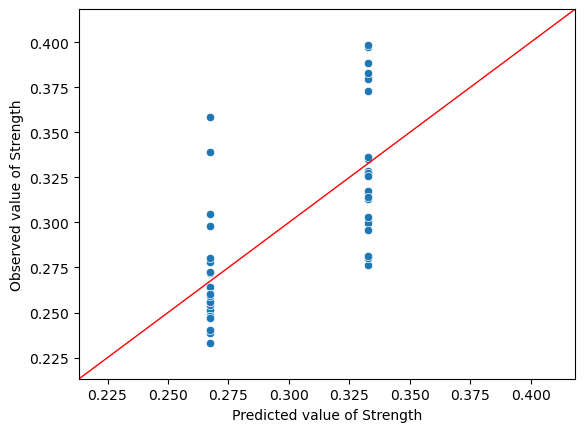

In [25]:
Y_max = Y.max()+0.02
Y_min = Y.min()-0.02

ax = sns.scatterplot(x=model_result.fittedvalues, y=Y)
ax.set(ylim=(Y_min, Y_max))
ax.set(xlim=(Y_min, Y_max))
ax.set_xlabel("Predicted value of Strength")
ax.set_ylabel("Observed value of Strength")

X_ref = Y_ref = np.linspace(Y_min, Y_max, 100)
plt.plot(X_ref, Y_ref, color='red', linewidth=1)
plt.show()

# multiple linear regression

In [26]:
# could do, for example, condition and speed vs. swing duration
# or condition and speed vs. swing duration
Y = df['Swing duration (lateral legs)']
X = df[['Condition','Speed (body lengths / sec cruising)']] 
X = sm.add_constant(X)
X.head(3)

,const,Condition,Speed (body lengths / sec cruising)
0,1.0,0,0.188211
1,1.0,1,0.149659
2,1.0,0,0.171954


In [27]:
model = sm.OLS(Y, X)
model_res = model.fit()
model_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     Swing duration (lateral legs)   R-squared:                       0.621
Model:                                       OLS   Adj. R-squared:                  0.603
Method:                            Least Squares   F-statistic:                     33.60
Date:                           Wed, 21 Feb 2024   Prob (F-statistic):           2.30e-09
Time:                                   12:30:34   Log-Likelihood:                 92.975
No. Observations:                             44   AIC:                            -180.0
Df Residuals:                                 41   BIC:                            -174.6
Df Model:                                      2                                         
Covariance Type:                       nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.3421      0.019     17.546      0.000       0.303       0.382
Condition                               0.0496      0.010      4.982      0.000       0.030       0.070
Speed (body lengths / sec cruising)    -0.3285      0.081     -4.046      0.000      -0.492      -0.165
==============================================================================
Omnibus:                        3.159   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.206   Jarque-Bera (JB):                2.979
Skew:                           0.591   Prob(JB):                        0.226
Kurtosis:                       2.524   Cond. No.                         20.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

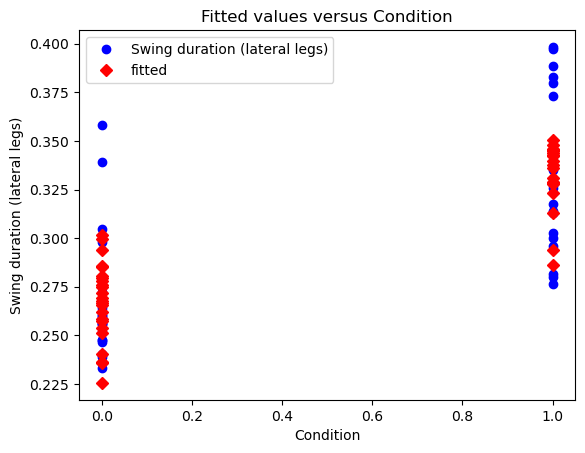

In [28]:
sm.graphics.plot_fit(model_res,1, vlines=False)
plt.show()

# Functions for pairwise boxplots and stats

Mann-Whitney U p-val 0.0


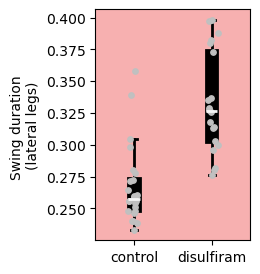

In [29]:
def compBoxPlot(ax,df,col): 
 
    # rearrange groupnames so 'control' is first
    groupnames = sorted(np.unique(df.treatment.values))
    if 'control' in groupnames:
        ind = groupnames.index('control')
        control = groupnames.pop(ind)
        groupnames.insert(0, control)
    
    # collect data
    data_to_plot = []
    for i,group in enumerate(groupnames):
        thisdata = df[df.treatment == group][col].values
        thisdata = thisdata[~np.isnan(thisdata)]
        data_to_plot.append(thisdata)
    
    # make boxplot
    bp = ax.boxplot(data_to_plot, patch_artist=True, showfliers=False)
    bp = gaitFunctions.formatBoxPlots(bp, ['black'], ['whitesmoke'], ['dimgrey'])
    
    # add scatter over the boxplot
    a = 1 # alpha
    sc = 'silver' # [ 0.76, 0.86, 0.85 ] # 'k' # color
    sz = 15 # marker size
    ji = 0.05 # jitter around midline
    for i, group in enumerate(groupnames):   
        xScatter = np.random.normal(i+1, ji, size=len(data_to_plot[i]))
        ax.scatter(xScatter, data_to_plot[i], s=sz, facecolors=sc, edgecolors=None , alpha = a, zorder = 2)
    
    # add axes labels
    ylab = col
    if '^2' in ylab:
        ylab = ylab.replace('^2','$^2$')
    if '/ sec cruising' in ylab:
        ylab = ylab.replace('/ sec', '/\nsec')
    if '(lateral' in ylab or '(rear' in ylab or '(normalized' in ylab:
        ylab = ylab.replace('(','\n(')
    ax.set_ylabel(ylab)
    ax.set_xticks(np.arange(len(groupnames))+1,groupnames)
    
    return ax, data_to_plot

def correctMultipleTests(ps,method): # method is 'bonferroni' or 'benjamini-hochberg' or 'benjamini-yekutieli'
    if method == 'bonferroni':
        adj_ps = [x*len(ps) for x in ps]
    elif method == 'benjamini-hochberg' or method == 'bh':
        adj_ps = [x for x in stats.false_discovery_control(ps)]
    elif method == 'benjamini-yekutieli' or method == 'by':
        adj_ps = [x for x in stats.false_discovery_control(ps, method='by')]
    else:
        print('No pvalue adjustment')
        adj_ps = ps
    return adj_ps

def facecolorPval(ax,pval):
    
    if pval < 0.001:
        fc = '#f7b0b0' # pinkish
    elif pval < 0.01:
        fc = '#fcca74' # orange-ish
    elif pval < 0.05:
        fc = '#f6f7a1' # yellow-ish
    else:
        fc = 'white'
    
    ax.set_facecolor(fc)

    return ax

def boxArray(maxcols,df,to_compare):

    if len(to_compare) % maxcols == 0:
        numrows = int(len(to_compare) / maxcols)
        cushion = 0
    else:
        numrows = int(len(to_compare) / maxcols) + 1
        cushion = maxcols - (len(to_compare) % maxcols)
    rows,cols = [numrows,maxcols]
    f,axes = plt.subplots(rows,cols,figsize = (8,2*numrows))
    axes_list = axes.reshape(1,len(to_compare)+cushion)[0]
    pvals = []
    tests = []
    for i, col in enumerate(to_compare):
        axes_list[i], data_to_plot = compBoxPlot(axes_list[i], df, col)
        pval,test = pairwiseStats(data_to_plot)# ,'kw')
        pvals.append(pval)
        tests.append(test)
        axes_list[i].yaxis.label.set_size(tick_fontsize)
        axes_list[i].tick_params(axis='both', which='major', labelsize=tick_fontsize)
    for i in np.arange(cushion):
        axes_list[-(i+1)].set_axis_off()
    print(tests)
    print([np.round(x,3) for x in pvals])

    # adjust p-values for multiple hypothesis testing
    adj_ps = correctMultipleTests(pvals,'by') # 'bonferroni' or 'bh' or 'by'
    print([np.round(x,3) for x in adj_ps])

    # recolor axes based on p-vals
    if cushion != 0:
        axes_list = axes_list[:-cushion]
    for i, ax in enumerate(axes_list):
        ax = facecolorPval(ax,adj_ps[i])

    plt.tight_layout()
    plt.show()


f,ax = plt.subplots(1,1,figsize=(2,3))
ax, data_to_plot = compBoxPlot(ax,df,'Swing duration (lateral legs)')
pval, test = pairwiseStats(data_to_plot)
ax = facecolorPval(ax,pval)
print(test, 'p-val', np.round(pval,4))
plt.show()


# Arrays of boxplots

['T-test', 'Mann-Whitney U', 'Mann-Whitney U', 'T-test', 'Mann-Whitney U']
[0.003, 0.014, 0.005, 0.007, 0.004]
[0.018, 0.031, 0.018, 0.021, 0.018]


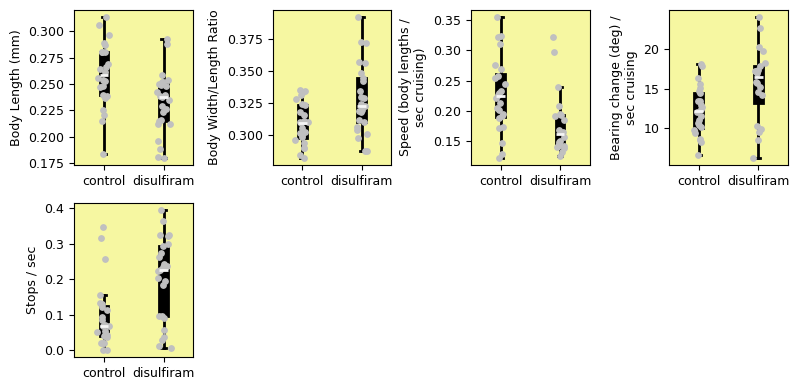

In [30]:
boxArray(4,path_summaries_df,path_cols)

['T-test', 'Mann-Whitney U', 'T-test', 'T-test', 'T-test', 'Mann-Whitney U', 'Mann-Whitney U', 'T-test', 'Mann-Whitney U', 'Mann-Whitney U', 'Mann-Whitney U']
[0.001, 0.0, 0.087, 0.69, 0.024, 0.0, 0.024, 0.357, 0.786, 0.316, 0.972]
[0.012, 0.0, 0.481, 1.0, 0.163, 0.0, 0.163, 1.0, 1.0, 1.0, 1.0]


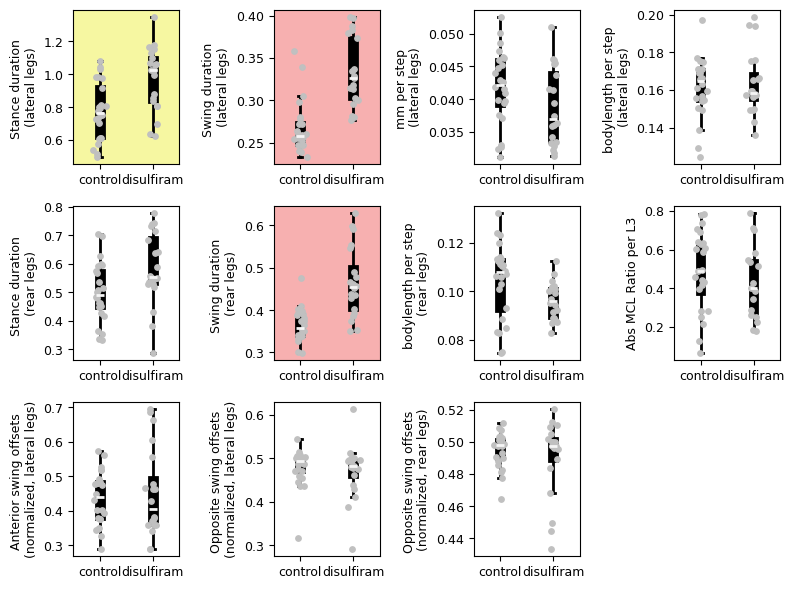

In [31]:
boxArray(4,step_summaries_df,step_cols)

['T-test', 'Mann-Whitney U', 'T-test', 'Mann-Whitney U', 'Mann-Whitney U']
[0.266, 0.511, 0.476, 0.147, 0.487]
[1.0, 1.0, 1.0, 1.0, 1.0]


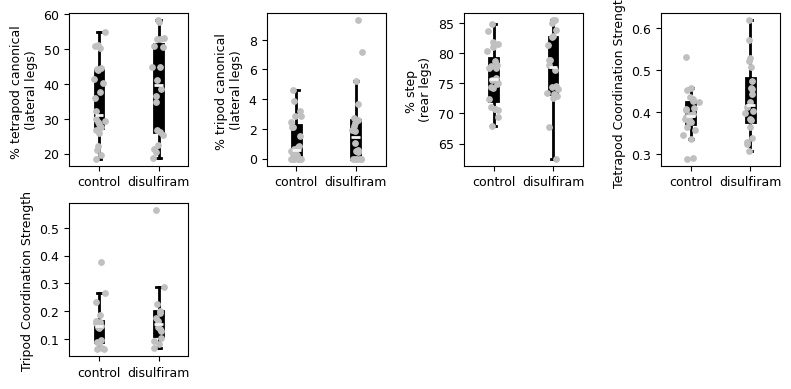

In [32]:
boxArray(4,gait_summaries_df,gait_cols)

# Phenotype Heatmaps and Multiple Comparisons


Body Length (mm) -0.15412437127810494 0.055323430809382936
Body Width/Length Ratio 0.08422381579259139 0.12929057944841424
Speed (body lengths / sec cruising) -0.34105132377303493 0.06191643296474527
Bearing change (deg) / sec cruising 0.3457206438031977 0.08130600127598885
Stops / sec 1.0772919398008072 0.055323430809382936
Stance duration (lateral legs) 0.3257712108320134 0.027882330657788442
Swing duration (lateral legs) 0.31571541095565864 0.00022101768415607877
mm per step (lateral legs) -0.11108913460373764 0.6044463980636449
bodylength per step (lateral legs) 0.017617371187550603 1.0
Stance duration (rear legs) 0.21877104713758436 0.18751829786271831
Swing duration (rear legs) 0.34883278618917246 0.000802217504019319
bodylength per step (rear legs) -0.11480789533662304 0.18751829786271831
Abs MCL Ratio per L3 -0.18588701424860862 1.0
Anterior swing offsets (normalized, lateral legs) 0.04807263690106321 1.0
Opposite swing offsets (normalized, lateral legs) -0.026783302883425467 

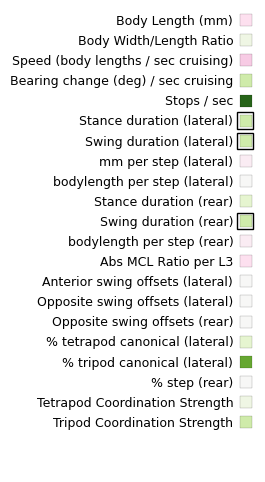

In [33]:
# function for Z-scores, Z-score plots, and combining dataframes
def pairZscore(data,conditions):
    # data is a vector of numbers for control and experimental treatments
    # conditions is a vector of 0 and 1 (for pairs), where
    # 'control' is assumed to be 0
    control_data = data[np.where(conditions==0)]
    exp_data = data[np.where(conditions==1)]
    control_mean = np.nanmean(control_data)
    control_std = np.nanstd(control_data)
    exp_std = np.nanstd(exp_data)
    zscores = np.zeros(len(data))
    for i, d in enumerate(data):
        if conditions[i] == 0: # control!
            zscores[i] = (d-control_mean)/control_std
        elif conditions[i] == 1:
            zscores[i] = (d-control_mean)/exp_std
    return zscores

def getLevelColor(cmap,level):
    colormap = mpl.colormaps[cmap]
    level_boundaries = np.linspace(-0.95,0.95,20)
    cmap_levels = np.linspace(0,1,21)
    
    for i, boundary in enumerate(level_boundaries):
        if level <= boundary:
            return colormap(cmap_levels[i])
        
    return colormap(cmap_levels[-1])

def ratioPlot(ax, dflist, colslist, control='control', cmap='bwr', plotLabels = True):
    '''
    Parameters
    
    dflist: a list of dataframes, usually path_summaries_df, step_summaries_df, gait_summaries_df
         or pdf, sdf, gdf
    colslist: a list of lists of columns within these dataframes
    '''

    # find total number of comparisons
    total_cols = np.sum(np.array([len(x) for x in colslist]))
    
    # make empty containers for zscore_ratios and pvals and labels
    log2ratios = np.zeros(total_cols)
    pvals = np.zeros(total_cols)
    labels = np.empty(total_cols, dtype='object')
    idx = 0 # index for these containers
    
    # go through dflist and colslist
    for i,columns in enumerate(colslist):
        
        df = dflist[i].copy()

        # set control to 0 and experimental to 1
        df['Condition'] = np.where(df['treatment'] == control, 0, 1)
        conditions = df['Condition'].values

        for column in columns:
            
            data = df[column].values
            
            control_data = data[np.where(conditions==0)]
            exp_data = data[np.where(conditions==1)]
            
            # remove nan (no data)
            control_data = control_data[~np.isnan(control_data)]
            exp_data = exp_data[~np.isnan(exp_data)]
    
            # get pval for this column            
            pval, test = pairwiseStats([control_data, exp_data])
#             print(column, pval, test) # testing
            pvals[idx] = pval
    
            # get label for this column
            labels[idx] = column
            
            # get log2(experiment/control) ratio for this column (CLR causes trouble!)
            log2ratios[idx] = np.log2(np.mean(exp_data)/np.mean(control_data))          
    
            idx += 1

    # correct pvals for multiple comparisons
    adj_pvals = correctMultipleTests(pvals,'by')
    
    ytext = 0.25 # level for text above the lower edge of each square

    ylevel = len(labels) + 1
    
    big_box = 0.4
    small_box = 0.3

    # go through data
    for i, label in enumerate(labels):
    
        # plot a square, with color scaled to log2_ratio
        square_color = getLevelColor(cmap, log2ratios[i])
        
        square_center_x = 0.5
        square_center_y = ylevel + 0.5
        
        # plot a thick border if significant
        if adj_pvals[i] < 0.05:
            linewidth = 0.1 # 0.1 or 3 or 5
            ec = 'k'
#             ax.text(0.25,ylevel,s='*',fontsize=axis_fontsize) # or comment out
            square = patches.Rectangle((square_center_x-big_box, square_center_y-big_box), 
                                       2*big_box, 2*big_box, linewidth=1, edgecolor='k', facecolor='w')        
            ax.add_patch(square)
        else:
            linewidth = 0.1
            ec = 'k'
        
        square = patches.Rectangle((square_center_x-small_box+0.025, square_center_y-small_box-0.01), 
                                   2*small_box, 2*small_box, linewidth=linewidth, 
                                   edgecolor=ec, facecolor=square_color)        
        ax.add_patch(square)
        
        # plot the text
        if plotLabels:
            label = label.replace('normalized, ','')
            label = label.replace(' legs','')
            ax.text(-0.1,ylevel+ytext,s=label,fontsize=tick_fontsize, horizontalalignment='right')

        # plot horizontal lines to separate the different dataframes ?
        
        # update ylevel
        ylevel = ylevel-1

    ax.set_ylim([0,len(labels) + 2])
    ax.set_aspect('equal')
#     ax.set_xlim([0,1])
    ax.set_axis_off()
    return ax, log2ratios, pvals, adj_pvals, labels

dfs = [path_summaries_df, step_summaries_df, gait_summaries_df]
cols = [path_cols, step_cols, gait_cols]
f,ax = plt.subplots(figsize=(2,6))
print()
ax, log2_ratios, pvals, adj_pvals, labels = ratioPlot(ax, dfs, cols, 
                                                      control, 'PiYG', True) # 'control' or 'exemplaris' or 'adult'

for i, lab in enumerate(labels):
    print(lab, log2_ratios[i], adj_pvals[i])
plt.show()

# ratio legend

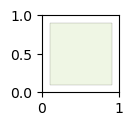

In [34]:
c = getLevelColor('PiYG', 0.1)
f,ax = plt.subplots(1,1,figsize=(1,1))
square = patches.Rectangle((0.1, 0.1), 0.8, 0.8, linewidth=0.1, edgecolor='k', facecolor=c)        
ax.add_patch(square)
plt.show()

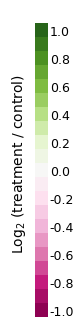

In [35]:
levels = np.linspace(-1,1,21)
ylevel = 0
f,ax = plt.subplots(figsize=(1,4))
cmap = 'PiYG'
for i, level in enumerate(levels):
    square_color = getLevelColor(cmap, level)
    square = patches.Rectangle((0.1, ylevel), 1, 1, linewidth=0.1, edgecolor=None, facecolor=square_color)        
    ax.add_patch(square)
    tenx = int(np.round(level*10,1))
    if tenx % 2 == 0:
        ax.text(1.15,ylevel+0.15,str(np.round(level,1)),fontsize=tick_fontsize)
    ylevel += 1
ax.set_ylabel('Log$_{2}$ (treatment / control)')
ax.set_ylim([0,len(levels)+1])
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)
ax.set_aspect('equal')
ax.set_yticks([])
ax.set_xticks([])
# ax.set_axis_off()
plt.show()

# Pairwise gait style comparisons

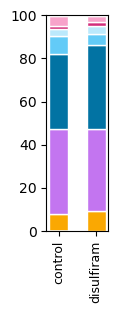

In [36]:
def gaitStylePercentagesPlot(ax, df, control='control', leg_set='lateral', addLegend=True):
    
    barWidth = 0.5
    df = df.copy()
    ylab = 'Percentage in Gait Style'

    # set up colors
    if leg_set in ['rear','two','human']:
        all_combos, combo_colors = gaitFunctions.get_gait_combo_colors('rear')
        columns = ['% stand (rear legs)', '% step (rear legs)','% hop (rear legs)']
        ylab += '\n(Rear Legs)'
    elif leg_set in ['four','cat','dog','tetrapod']:
        all_combos, combo_colors = gaitFunctions.get_gait_combo_colors('four')
    elif leg_set in ['lateral','insect','six']:
        all_combos, combo_colors = gaitFunctions.get_gait_combo_colors('lateral')
        columns = [x for x in gdf.columns if '%' in x]
        columns = [x for x in columns if 'lateral' in x]
        columns = [x for x in columns if 'total' not in x]
        ylab += '\n(Lateral Legs)'
#     print(combo_colors) # test OK
#     print(columns) # test OK
    
    # set control to 0 and experimental to 1
    df['Condition'] = np.where(df['treatment'] == control, 0, 1)
    conditions = df['Condition'].values
    exp_name = np.unique(df.treatment.values[np.where(conditions==1)])[0]
#     print(exp_name)
  
    bottoms = [0,0]
    for c, column in enumerate(columns):
        data = df[column].values
        control_mean = np.mean(data[np.where(conditions==0)])
        exp_mean = np.mean(data[np.where(conditions==1)])
        for i, val in enumerate([control_mean, exp_mean]):
            if i == 0: # plot for legend
                ax.bar(i, 0, bottom = 0, color = combo_colors[all_combos[c]],
                       edgecolor='white', width=barWidth, label=all_combos[c].replace('_',' '))
            ax.bar(i, val, bottom=bottoms[i], color=combo_colors[all_combos[c]],
                  edgecolor='white',width=barWidth)
            bottoms[i] += val
    
    ax.set_xticks(np.arange(2))
    ax.set_xticklabels([control, exp_name], fontsize=tick_fontsize, rotation=90)
    
    # Add a legend
    if addLegend:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(reversed(handles), reversed(labels), loc='upper left',
                  bbox_to_anchor=(1,1), ncol=1, fontsize=tick_fontsize)
        ax.set_ylabel(ylab, fontsize=axis_fontsize)
    ax.set_ylim([0,100]) 

    return ax

df = gait_summaries_df.copy()
f, ax = plt.subplots(1,1,figsize=(0.8,2.8))
ax = gaitStylePercentagesPlot(ax, df, control, 'lateral', False) # False to hide legend and Y label
plt.show()

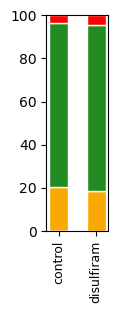

In [37]:
df = gait_summaries_df.copy()
f, ax = plt.subplots(1,1,figsize=(0.8,2.8))
ax = gaitStylePercentagesPlot(ax, df, control, 'rear', False) # False to hide legend and Y label
plt.show()

# ternary plots and compositional statistics

In [5]:
from gaitFunctions import colorBoxplot
from gaitFunctions import pairwiseStats
import mpltern
import composition_stats as cs
gait_summaries_df.head(5)

,Identifier,treatment,individual,date,Number of frames,% stand (lateral legs),% pentapod (lateral legs),% tetrapod canonical (lateral legs),% tetrapod gallop (lateral legs),% tetrapod other (lateral legs),...,CLR pentapod (lateral legs),CLR tetrapod canonical (lateral legs),CLR tetrapod gallop (lateral legs),CLR tetrapod other (lateral legs),CLR tripod canonical (lateral legs),CLR tripod other (lateral legs),CLR other (lateral legs),CLR stand (rear legs),CLR step (rear legs),CLR hop (rear legs)
0,iw_12jan_tardigrade01_control,control,tardigrade01,12jan,360,9.166667,45.000000,29.444444,10.833333,3.611111,...,0.140929,-0.063348,0.985427,0.747022,-2.264595,0.926511,-0.998702,0.267377,0.013954,-1.215488
1,iw_12jan_tardigrade01_disulfiram,disulfiram,tardigrade01,12jan,363,11.019284,42.148760,36.363636,7.988981,2.203857,...,0.075472,0.147716,0.680862,0.253215,-2.264595,-1.027698,-0.998702,-0.208519,0.113211,-0.664172
2,iw_12jan_tardigrade02_control,control,tardigrade02,12jan,640,11.718750,50.625000,26.875000,7.968750,1.406250,...,0.258713,-0.154657,0.678326,-0.196067,2.185382,0.014674,-0.998702,0.541030,-0.095536,-0.779252
3,iw_12jan_tardigrade02_disulfiram,disulfiram,tardigrade02,12jan,558,9.677419,53.584229,18.817204,12.544803,4.480287,...,0.315522,-0.511082,1.132105,0.962693,-2.264595,0.151784,-0.998702,-0.313053,0.133744,-0.842813
4,iw_12jan_tardigrade03_control,control,tardigrade03,12jan,559,6.797853,33.631485,50.805009,3.577818,0.894454,...,-0.150270,0.482142,-0.122448,-0.648535,3.706995,0.619997,-0.998702,0.276025,-0.074558,0.671744


In [6]:
exp = gait_summaries_df[gait_summaries_df['treatment']==experimental]
con = gait_summaries_df[gait_summaries_df['treatment']==control]
print(np.shape(exp), np.shape(con))

(20, 33) (24, 33)


In [7]:
stand_rear_exp = exp['% stand (rear legs)'].values
stand_rear_con = con['% stand (rear legs)'].values
step_rear_exp = exp['% step (rear legs)'].values
step_rear_con = con['% step (rear legs)'].values
hop_rear_exp = exp['% hop (rear legs)'].values
hop_rear_con = con['% hop (rear legs)'].values
exp_color = 'tab:red'
con_color = 'tab:blue'

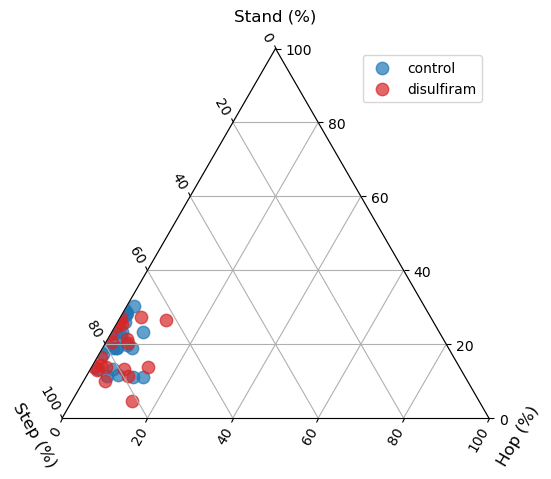

In [9]:
ax = plt.subplot(projection="ternary", ternary_sum=100.0)

ax.scatter(stand_rear_con, step_rear_con, hop_rear_con,c=con_color,s=80,alpha=0.7,label=control)
ax.scatter(stand_rear_exp, step_rear_exp, hop_rear_exp,c=exp_color,s=80,alpha=0.7,label=experimental)

ax.set_tlabel("Stand (%)", fontsize=12)
ax.set_llabel("Step (%)", fontsize=12)
ax.set_rlabel("Hop (%)", fontsize=12)

ax.grid()
ax.legend()

plt.show()

In [10]:
stand_lateral_exp = exp['% stand (lateral legs)'].values
stand_lateral_con = con['% stand (lateral legs)'].values

pentapod_exp = exp['% pentapod (lateral legs)'].values
pentapod_con = con['% pentapod (lateral legs)'].values

tetrapod_canonical_exp = exp['% tetrapod canonical (lateral legs)'].values
tetrapod_canonical_con = con['% tetrapod canonical (lateral legs)'].values

tetrapod_gallop_exp = exp['% tetrapod gallop (lateral legs)'].values
tetrapod_gallop_con = con['% tetrapod gallop (lateral legs)'].values

tetrapod_other_exp = exp['% tetrapod other (lateral legs)'].values
tetrapod_other_con = con['% tetrapod other (lateral legs)'].values

tetrapod_total_exp = exp['% tetrapod total (lateral legs)'].values
tetrapod_total_con = con['% tetrapod total (lateral legs)'].values

tripod_canonical_exp = exp['% tripod canonical (lateral legs)'].values
tripod_canonical_con = con['% tripod canonical (lateral legs)'].values

tripod_other_exp = exp['% tripod other (lateral legs)'].values
tripod_other_con = con['% tripod other (lateral legs)'].values

tripod_total_exp = exp['% tripod total (lateral legs'].values
tripod_total_con = con['% tripod total (lateral legs'].values

# 'total' here is pentapod + tetrapod + tripod
total_exp =  pentapod_exp + tetrapod_total_exp + tripod_total_exp
total_con =  pentapod_con + tetrapod_total_con + tripod_total_con

pentapod_percent_exp = pentapod_exp / total_exp
tetrapod_percent_exp = tetrapod_total_exp / total_exp
tripod_percent_exp = tripod_total_exp / total_exp
# print(pentapod_percent_exp + tetrapod_percent_exp + tripod_percent_exp)# testing OK

pentapod_percent_con = pentapod_con / total_con
tetrapod_percent_con = tetrapod_total_con / total_con
tripod_percent_con = tripod_total_con / total_con
# print(pentapod_percent_con + tetrapod_percent_con + tripod_percent_con)# testing OK


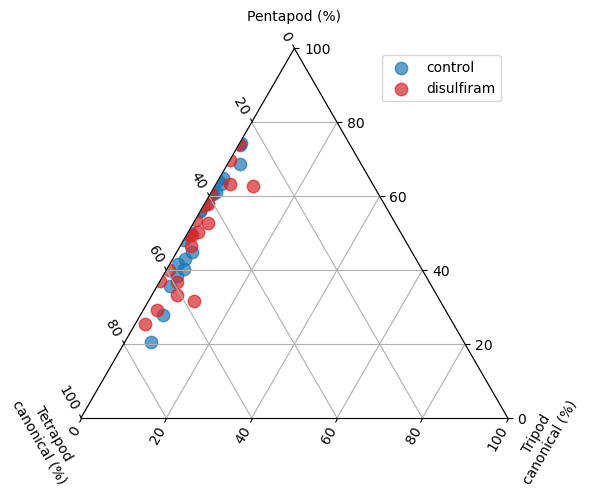

In [11]:
ax = plt.subplot(projection="ternary", ternary_sum=100.0)

# total
# ax.scatter(pentapod_percent_con, tetrapod_percent_con, tripod_percent_con,c=con_color,s=10,label=control)
# ax.scatter(pentapod_percent_exp, tetrapod_percent_exp, tripod_percent_exp,c=exp_color,s=10,label=experimental)
# ax.set_tlabel("Pentapod (%)")
# ax.set_llabel("Tetrapod (%)")
# ax.set_rlabel("Tripod (%)")

# canonical
ax.scatter(pentapod_con, tetrapod_canonical_con, tripod_canonical_con, c=con_color,s=80,alpha=0.7,label=control)
ax.scatter(pentapod_exp, tetrapod_canonical_exp, tripod_canonical_exp, c=exp_color,s=80,alpha=0.7,label=experimental)
ax.set_tlabel("Pentapod (%)")
ax.set_llabel("Tetrapod\ncanonical (%)")
ax.set_rlabel("Tripod\ncanonical (%)")

ax.grid()
ax.legend()

plt.show()

# compositional data = log ratio transform

In [12]:
# rear legs
labs = ['stand','step','hop']
treatments = gait_summaries_df.treatment.values
control_ix = np.where(treatments == control)[0]
exp_ix = np.where(treatments == experimental)[0]
rear_percentages = np.hstack([[
    gait_summaries_df['% stand (rear legs)'].values,
    gait_summaries_df['% step (rear legs)'].values,
    gait_summaries_df['% hop (rear legs)'].values
                             ]])
print(np.sum(rear_percentages,0)) # should all be 100 ... check!
rear_percentages_nozeros = cs.multiplicative_replacement(rear_percentages)
print(np.sum(rear_percentages_nozeros,0)) # should still be 100-ish ... check!
rear_clr = cs.clr(rear_percentages_nozeros)

[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100.]
[ 99.99827824  99.99701182  99.99733665  99.99750067  99.98863452
  99.97800587  99.98266383  99.99818124  99.98954824  99.99282599
  99.99576101  99.98290897  99.99920534 100.00051653 100.00051653
  99.99867783  99.99885499  99.99473973  99.99639631  99.992502
  99.99236946  99.99226454  99.99623465  99.99898277  99.99857575
  99.99921341  99.99856961  99.99200459  99.9879253  100.00051653
  99.99908036  99.99712151  99.99951726  99.99841474  99.99805694
  99.97916995  99.97938577  99.98863511  99.99750641  99.99181996
  99.98503514  99.9953345   99.99207598  99.99481638]


In [13]:
print(gait_summaries_df.columns)

Index(['Identifier', 'treatment', 'individual', 'date', 'Number of frames',
       '% stand (lateral legs)', '% pentapod (lateral legs)',
       '% tetrapod canonical (lateral legs)',
       '% tetrapod gallop (lateral legs)', '% tetrapod other (lateral legs)',
       '% tetrapod total (lateral legs)', '% tripod canonical (lateral legs)',
       '% tripod other (lateral legs)', '% tripod total (lateral legs',
       '% other (lateral legs)', '% stand (rear legs)', '% hop (rear legs)',
       '% step (rear legs)', 'Tetrapod Coordination Strength',
       'Tetrapod Bout Speed (bodylength / s)', 'Tripod Coordination Strength',
       'Tripod Bout Speed (bodylength / s)', 'CLR stand (lateral legs)',
       'CLR pentapod (lateral legs)', 'CLR tetrapod canonical (lateral legs)',
       'CLR tetrapod gallop (lateral legs)',
       'CLR tetrapod other (lateral legs)',
       'CLR tripod canonical (lateral legs)',
       'CLR tripod other (lateral legs)', 'CLR other (lateral legs)',
       'CLR

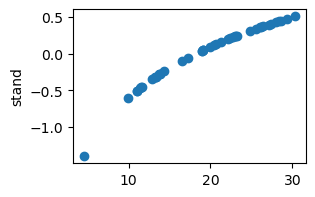

In [14]:
# rear_clr should still be proportional to rear_percentages, no?
col = 0 # 0=stand, 1=step, 2=hop
f,a = plt.subplots(1,1,figsize=(3,2))
a.scatter(rear_percentages[0],rear_clr[0])
a.set_ylabel(labs[col])
plt.show()
# yes, in a loggish way

p =  0.521267 by T-test


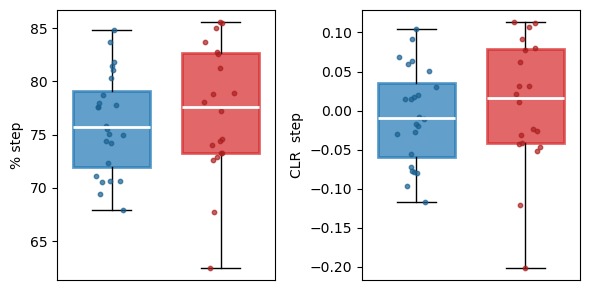

In [15]:
# REAR boxplot
col = 1 # 0=stand, 1=step, 2=hop

f,[a1,a2] = plt.subplots(1,2,figsize=(6,3))
rear_boxdata = [rear_percentages[col][control_ix], rear_percentages[col][exp_ix]]
a1,bp1=colorBoxplot(a1,rear_boxdata,[con_color,exp_color],10,0.8)
a1.set_ylabel('% ' + labs[col])

rear_clr_boxdata = [rear_clr[col][control_ix], rear_clr[col][exp_ix]]
a2,bp2=colorBoxplot(a2,rear_clr_boxdata,[con_color,exp_color],10,0.8)
a2.set_ylabel('CLR  '+ labs[col])

plt.tight_layout()

pval, test = pairwiseStats(rear_clr_boxdata)
print('p = ', np.round(pval,6), 'by', test)
plt.show()

In [16]:
# LATERAL legs
lateral_percentages = np.hstack([[
    gait_summaries_df['% stand (lateral legs)'].values,
    gait_summaries_df['% pentapod (lateral legs)'].values,
    gait_summaries_df['% tetrapod canonical (lateral legs)'].values,
    gait_summaries_df['% tetrapod gallop (lateral legs)'].values,
    gait_summaries_df['% tetrapod other (lateral legs)'].values,
    gait_summaries_df['% tripod canonical (lateral legs)'].values,
    gait_summaries_df['% tripod other (lateral legs)'].values,
    gait_summaries_df['% other (lateral legs)'].values
                             ]])
labs = ['stand','pentapod','tetrapod canonical','tetrapod gallop','tetrapod other',
       'tripod canonical','tripod other',' other']

print(np.sum(lateral_percentages,0)) # should all be 100 ... check!
lateral_percentages_nozeros = cs.multiplicative_replacement(lateral_percentages)
print(np.sum(lateral_percentages_nozeros,0)) # should still be 100-ish ... check!
lateral_clr = cs.clr(lateral_percentages_nozeros)

[100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100.]
[ 99.97190657  99.9818233   99.97719202  99.96909713  99.97076298
  99.91943815  99.92157028  99.96450501  99.95310493 100.00258264
  99.9801521   99.95849538  99.96350745  99.97239661  99.99204995
  99.9768937   99.98257796  99.97312442  99.9674365   99.96822514
  99.962266    99.95458538  99.96907585  99.98808367  99.99353199
  99.9935683   99.96551176  99.9347676   99.95003757  99.96114592
  99.97043523  99.92715183  99.97203503  99.95851916  99.98111674
  99.92747014  99.92459884  99.90301328  99.98279424  99.95195187
  99.93502517  99.95903146  99.94864059  99.95334746]


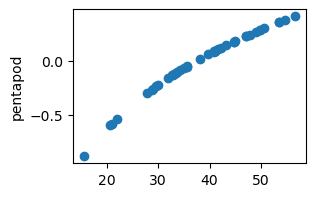

In [18]:
# lateral clr should still be proportional to lateral percentages, no?
col = 1 # 0=stand 1=pentapod 2=tetrapod canonical 3=tetrapod gallop 4=tetrapod other
#         5=tripod canonical 6=tripod other 7=other
f,a = plt.subplots(1,1,figsize=(3,2))
a.scatter(lateral_percentages[col],lateral_clr[col])
a.set_ylabel(labs[col])
plt.show()
# yes, in a loggish way

p =  0.327993 by Mann-Whitney U


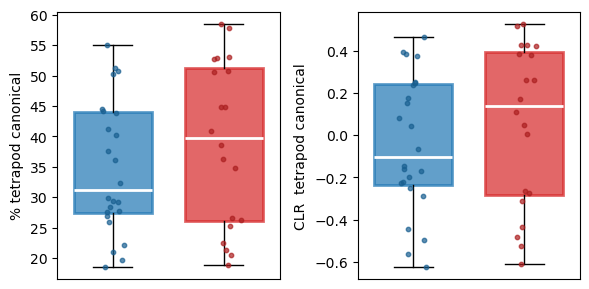

In [19]:
# LATERAL boxplot a:  % for ex vs. ram, 2: clr for ex vs. ram
col = 2 # 0=stand 1=pentapod 2=tetrapod canonical 3=tetrapod gallop 4=tetrapod other
#         5=tripod canonical 6=tripod other 7=other
f,[a1,a2] = plt.subplots(1,2,figsize=(6,3))
lateral_boxdata = [lateral_percentages[col][control_ix], lateral_percentages[col][exp_ix]]
a1,bp1=colorBoxplot(a1,lateral_boxdata,[con_color,exp_color],10,0.8)
a1.set_ylabel('% ' + labs[col])

lateral_clr_boxdata = [lateral_clr[col][control_ix], lateral_clr[col][exp_ix]]
a2,bp2=colorBoxplot(a2,lateral_clr_boxdata,[con_color,exp_color],10,0.8)
a2.set_ylabel('CLR  '+ labs[col])

pval, test = pairwiseStats(lateral_clr_boxdata)
print('p = ', np.round(pval,6), 'by', test)

plt.tight_layout()
plt.show()

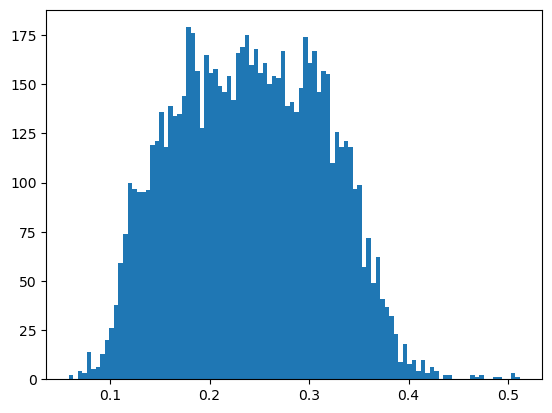

In [39]:
# Swing duration in different speed bins

# add column of speed body-length / sec to step_timing_df
# need to divide speed_during_step_scaled by bodylength for every line
# print(step_timing_df.columns)
# print(path_summaries_df.columns)

bodylength_dict = dict(zip(path_summaries_df.Identifier.values,path_summaries_df['Body Length (mm)'].values))
# print(bodylength_dict)

uniq_ids = step_timing_df.uniq_id.values
scaled_speeds = step_timing_df['speed_during_step_scaled'].values
speed_bodylength = [scaled_speeds[i]/bodylength_dict[uniq_id] for i,uniq_id in enumerate(uniq_ids)]
step_timing_df['Speed (bodylength / step)'] = speed_bodylength

plt.hist(speed_bodylength,bins=100)
plt.show()

In [ ]:
# for each speed bin (0.05 of bodylengths), get number of steps in each treatment
# and get swing duration for each of these steps 
# (we are trying to see if swing durations differ in same speed bin)

# SCRUNCH from Emma data of adults vs. juveniles

In [ ]:
baby_scrunch_time = np.array([0.02542372881, 0.1206896552, 0.08064516129,0.03921568627,0,0,0,0.03703703704,0.02575107296,0.01652892562,0.01,0.0701754386,0.08333333333,0.03703703704,0.08571428571])
baby_st_time = np.array([0.07627118644,0,
0.008064516129,
0.01307189542,
0.06140350877,
0,
0.04,
0.02469135802,
0.02575107296,
0.03305785124,
0.03,
0.01754385965,
0.02083333333,
0.03703703704,
0.02857142857])
adult_scrunch_time = np.array([
    0,
0,
0.02702702703,
0.07407407407,
0.05660377358,
0.01724137931,
0.06382978723,
0.075,
0,
0.1,
])
adult_st_time = np.array([
    0.01818181818,
0.01785714286,
0.02702702703,
0.03703703704,
0.05660377358,
0.08620689655,
0.06382978723,
0.05,
0,
0
])

In [ ]:
f,[a1,a2] = plt.subplots(1,2,figsize=(7,3))
scrunch_boxdata = [adult_scrunch_time, baby_scrunch_time]
st_boxdata = [adult_st_time, baby_st_time]

a1,bp1=colorBoxplot(a1,scrunch_boxdata,[con_color,exp_color],10,0.8)
a1.set_ylabel('Scrunch / sec')

a2,bp2=colorBoxplot(a2,st_boxdata,[con_color,exp_color],10,0.8)
a2.set_ylabel('Scrunch-turn / sec')

pval, test = pairwiseStats(scrunch_boxdata)
print('Scrunch p = ', np.round(pval,6), 'by', test)

pval, test = pairwiseStats(st_boxdata)
print('Scrunch-turn p = ', np.round(pval,6), 'by', test)

plt.tight_layout()
plt.show()
